# Process bulk RNA-sequencing data 

This notebook includes:

* Processing and module scoring of our original T-ALL cohort
* Processing and module scoring of our PMC cohort 
* Scoring of the COG cohort (Transcript per million (TPM) counts were downloaded from the KidsFirst portal https://portal.kidsfirstdrc.org/; accessed November 2023)

The following code was executed using an R kernel in Jupyterhub, but could be copied over to an R script instead.

In [1]:
##### ----- Load libraries
requiredPackages <- c("Matrix","edgeR","GSEABase",  "org.Hs.eg.db", "data.table",
                      "dplyr", "viridis","cowplot", "ggplot2", "singscore", "biomaRt") 

for (pkg in requiredPackages){
  suppressWarnings(suppressMessages(library(pkg, character.only = T)))
}


##### ----- Directories
data_dir = "/lustre/scratch126/casm/team274sb/bl10/T-ALL/Data/Bulk_RNA/DavidOConnor/"
save_dir = "/lustre/scratch126/casm/team274sb/hw12/T_ALL/data/"

##### ----- Module
module_genes = c('ZBTB16','KLRB1','LINC00299','TNFRSF25','EPHA4','ITGB7','PLXNA4','FRY','MYO1F','ST8SIA1','PCED1B-AS1','NTRK1',
                 'FURIN','TSPAN32','NR4A3','KIT','SLC24A3','SEMA7A','TRBV2','ITGA9','NNMT','TUBB4A','GATA1','STAR','FAM110A','CDKN1C','TRH','CCPG1','PTGER2')

<br>

## Process and score original T-ALL cohort

### Load data

In [2]:
xx = lapply(list.files(paste0(data_dir,"STAR_output")), 
       function(i){
    x = read.table(paste0(data_dir,"STAR_output/",i,'/',i,".feature_counts.tsv"), sep="\t", header=TRUE, skip = 1, row.names = 1)
    as.data.frame(x[,6:ncol(x)], row.names=rownames(x))
       })
dat_x <- do.call("cbind", xx)
colnames(dat_x) <- list.files(paste0(data_dir,"STAR_output"))

In [3]:
bulk_meta_data <- read.table(paste0(data_dir,"TALL_bulk_rna_metadata.csv"), sep=",", 
                             header=TRUE)
head(bulk_meta_data)

,Patient_ID,Sample_ID,File,Source,Disease,Timepoint,Tissue,ETP_status,Genetics,Response,Experiment,Has_scRNA
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,P011,P011_D0_bulkRNA,R0058,DavidOConnor,T-ALL,D0,BM,nonETP,TLX3,nonResponsive,bulkRNA,No
2,P013,P013_D0_bulkRNA,R0027,DavidOConnor,T-ALL,D0,BM,ETP,HOX,nonResponsive,bulkRNA,No
3,P016,P016_D0_bulkRNA,R0048,DavidOConnor,T-ALL,D0,BM,nonETP,TAL1,nonResponsive,bulkRNA,Yes
4,P017,P017_D0_bulkRNA,R0049,DavidOConnor,T-ALL,D0,BM,ETP,HOX,nonResponsive,bulkRNA,No
5,P018,P018_D0_bulkRNA,R0028,DavidOConnor,T-ALL,D0,BM,nonETP,Other,nonResponsive,bulkRNA,Yes
6,P019,P019_D0_bulkRNA,R0030,DavidOConnor,T-ALL,D0,BM,ETP,HOX,nonResponsive,bulkRNA,Yes


### Make DGE object

In [4]:
group_x <- factor(as.vector(setNames(bulk_meta_data$Response, bulk_meta_data$File)[colnames(dat_x)]))
ETP_x <- factor(as.vector(setNames(bulk_meta_data$ETP_status, bulk_meta_data$File)[colnames(dat_x)]))

T_dge <- DGEList(dat_x, group=group_x)
T_dge$design <- model.matrix( ~0 + group_x + ETP_x)
T_dge$samples$Genetics <- as.vector(setNames(bulk_meta_data$Genetics, bulk_meta_data$File)[rownames(T_dge$samples)])
T_dge$samples$Patient_ID <- as.vector(setNames(bulk_meta_data$Patient_ID, bulk_meta_data$File)[rownames(T_dge$samples)])
T_dge$samples$Has_scRNA <- as.vector(setNames(bulk_meta_data$Has_scRNA, bulk_meta_data$File)[rownames(T_dge$samples)])
T_dge$samples$ETP_status <- as.vector(setNames(bulk_meta_data$ETP_status, bulk_meta_data$File)[rownames(T_dge$samples)])

colnames(T_dge$counts) <- T_dge$samples$Patient_ID

#### Convert IDs & add gene lengths

In [5]:
## -- Get gene lengths
x = read.table(paste0(data_dir,"STAR_output/R0027/R0027.feature_counts.tsv"), sep="\t", header=TRUE, skip = 1, row.names = 1)
GeneLengths <- as.vector(setNames(x$Length, rownames(x))[rownames(T_dge)])

In [6]:
## -- Genome: GRCh38_v32_modified
ensembl_obj <- useEnsembl(biomart='ENSEMBL_MART_ENSEMBL', dataset="hsapiens_gene_ensembl") # host="https://oct2018.archive.ensembl.org"
annot <- biomaRt::getBM(attributes=c('ensembl_gene_id','version', 'external_gene_name',  'gene_biotype', 'hgnc_symbol'), 
                        mart = ensembl_obj)
annot <- annot[!(duplicated(annot$external_gene_name)),]

In [7]:
idx <- match(rownames(T_dge), annot$ensembl_gene_id)
T_dge <- T_dge[which(!is.na(idx)),]
GeneLengths <- GeneLengths[which(!is.na(idx))]
idx <- idx[!is.na(idx)] 
T_dge$genes <- annot[idx,] 
  
rownames(T_dge$genes) <- T_dge$genes$ensembl_gene_id
T_dge$genes$Length <- GeneLengths
rownames(T_dge) <- T_dge$genes$external_gene_name

### Process DGE

In [8]:
## -- Gene Filtering
T_dge <- T_dge[filterByExpr(T_dge, design=T_dge$design), keep.lib.sizes=FALSE] 

## -- Calculate Factors & Dispersions
T_dge <- calcNormFactors(T_dge)  # normalise by library size
T_dge <- estimateDisp(T_dge, T_dge$design, robust = TRUE)

In [9]:
## --- RPKM/CPM
T_dge$RPKM <- rpkm(T_dge, gene.length=T_dge$genes$Length)
T_dge$logRPKM <- rpkm(T_dge, log=TRUE, prior.count = 1, gene.length=T_dge$genes$Length)
T_dge$logCPM <- cpm(T_dge, log=TRUE, prior.count = 1)

### Score data

In [15]:
rankData <- rankGenes(T_dge$logRPKM)
scoredf <- simpleScore(rankData, upSet = module_genes,centerScore=FALSE)
T_dge$samples$Module_score_up <- as.vector(scoredf$TotalScore)

Warning message in checkGenes(upSet, rownames(rankData)):
“3 genes missing: SEMA7A, ITGA9, CDKN1C”


### Save

In [16]:
save(T_dge, file=paste0(save_dir, "T_dge.Rdata"))

<br>

<br>

## Process and score PMC cohort

### Load

In [2]:
## -- Read RDS
PMC_data = readRDS("/lustre/scratch126/casm/team274sb/hw12/T_ALL/data/20240223_T_ALL_Behjati_pseudo.rds")

metadata <- PMC_data$metaData

## -- Build DGE object
PMC_dge <- edgeR::DGEList(PMC_data$rawCounts,
                      group=as.vector(setNames(metadata$Disease_sub_specification1,
                                    metadata$BiomaterialID)[colnames(PMC_data$rawCounts)]))
PMC_dge$samples$materialType <- as.vector(setNames(metadata$materialType,
                                    metadata$BiomaterialID)[colnames(PMC_data$rawCounts)])
PMC_dge$samples$Disease_sub_specification2 <- as.vector(setNames(metadata$Disease_sub_specification2,
                                   metadata$BiomaterialID)[colnames(PMC_data$rawCounts)])
PMC_dge$samples$Disease_sub_specification1 <- as.vector(setNames(metadata$Disease_sub_specification1,
                                    metadata$BiomaterialID)[colnames(PMC_data$rawCounts)])

PMC_dge$samples$patient_ID <- rownames(PMC_dge$samples)

In [3]:
## -- Add MRD metadata
library(readxl)
MRD_dat <- read_excel("/lustre/scratch126/casm/team274sb/hw12/T_ALL/data/20240223_metaData_T_ALL_Behjati_pseudo_ammended.xlsx")

PMC_dge$samples$MRD <- as.vector(setNames(as.numeric(MRD_dat$`MRD`), MRD_dat$`...1`)[PMC_dge$samples$patient_ID])

## -- MRD by split
MRD_x <- replace(PMC_dge$samples$MRD,PMC_dge$samples$MRD>=5,">5")
MRD_x <- replace(MRD_x,(PMC_dge$samples$MRD>0)&(PMC_dge$samples$MRD<1),"0-1")
MRD_x <- replace(MRD_x,(PMC_dge$samples$MRD>=1)&(PMC_dge$samples$MRD<5),"1-5")
MRD_x <- replace(MRD_x,PMC_dge$samples$MRD==0,"0")
PMC_dge$samples$MRD_split <- MRD_x

New names:
• `` -> `...1`
Warning message in setNames(as.numeric(MRD_dat$MRD), MRD_dat$...1):
“NAs introduced by coercion”


keep
FALSE  TRUE 
40861 17943 


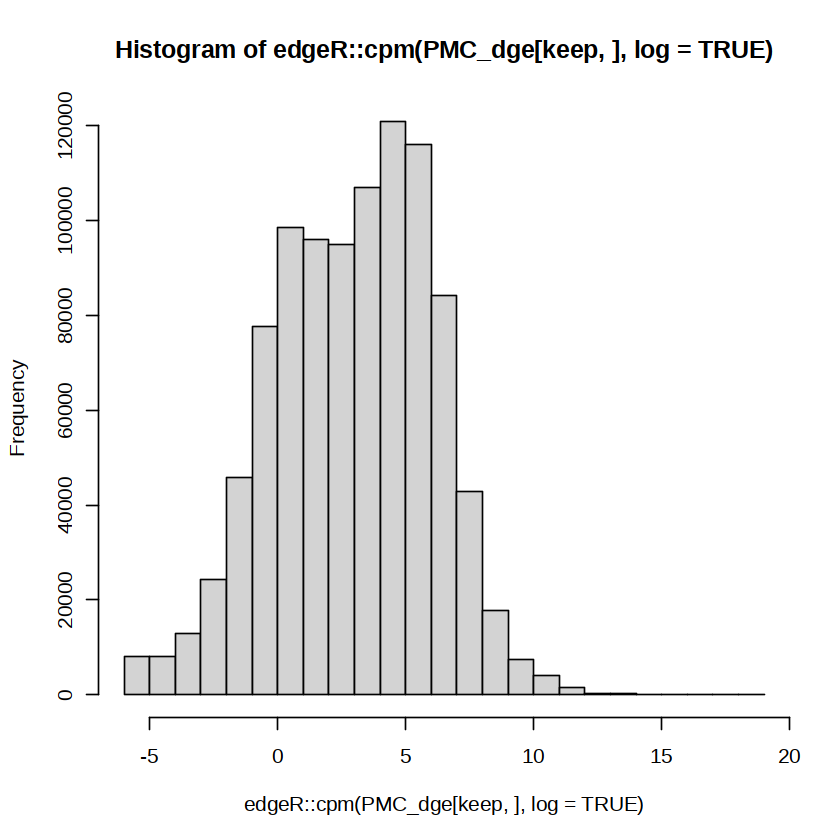

In [4]:
## -- Filter genes
keep = rowMeans(edgeR::cpm(y=PMC_dge, log = TRUE) >= 0.5) >= 0.1
hist(edgeR::cpm(PMC_dge[keep, ], log = TRUE))
print(table(keep))

In [5]:
PMC_dge <- PMC_dge[keep, ]

In [6]:
## -- Normalise
PMC_dge <- edgeR::calcNormFactors(PMC_dge)
PMC_dge$logCPM <- edgeR::cpm(PMC_dge, log=TRUE, prior.count = 1,
                             normalized.lib.sizes=TRUE, lib.size=PMC_dge$samples$lib.size)

#normLibSizes() ?

## -- Estimate Dispersions
PMC_dge <- estimateDisp(PMC_dge, PMC_dge$design, robust = TRUE)

Using classic mode.



### Score data

In [7]:
rankData <- rankGenes(PMC_dge$logCPM)
scoredf <- simpleScore(rankData, upSet = module_genes,centerScore=FALSE)
PMC_dge$samples$Module_score_up <- as.vector(scoredf$TotalScore)

Warning message in checkGenes(upSet, rownames(rankData)):
“1 genes missing: TRBV2”


### Save

In [8]:
save(PMC_dge, file=paste0(save_dir, "PMC_dge.Rdata"))

<br>

## Load and score COG data

In [14]:
## -- Load as DGE object
load(paste0(save_dir, "COG_dge.Rdata")) #COG_dge

In [10]:
## -- Drop 5 samples not included in metadata
COG_dge <- COG_dge[,!(colnames(COG_dge) %in% c('PATPKZ','PASKRY','PAUTWX','PAVCTK','PASVJP'))]
COG_dge$logTPM <- COG_dge$logTPM[,!(colnames(COG_dge$logTPM) %in% c('PATPKZ','PASKRY','PAUTWX','PAVCTK','PASVJP'))]

In [11]:
## -- Drop low purity ( < 60% blasts)
patients_to_keep = rownames(COG_dge$samples)[COG_dge$samples$D0_blasts>60]
patients_to_keep = patients_to_keep[!(is.na(patients_to_keep))]

COG_dge$logTPM <- COG_dge$logTPM[,patients_to_keep]
COG_dge <- COG_dge[,patients_to_keep]

### Score data

In [12]:
rankData <- rankGenes(COG_dge$logTPM)
scoredf <- simpleScore(rankData, upSet = module_genes,centerScore=FALSE)
COG_dge$samples$Module_score_up <- as.vector(scoredf$TotalScore)

Warning message in checkGenes(upSet, rownames(rankData)):
“4 genes missing: TNFRSF25, FRY, TRBV2, CDKN1C”


### Save

In [33]:
save(COG_dge, file=paste0(save_dir, "COG_dge.Rdata"))